# 01 SCADA Data Preprocessing
This notebook demonstrates how the available SCADA data is prepared for the case study. First, a dataset containing only normal operating conditions is obtained by filtering first by status code and then graphically using power, pitch and load curves. The latter is implemented using NRELs OpenOA toolbox. The turbulence intensity and air density are estimated based on available measurements.

## General Notebook Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import os
import sys
sys.path.append('../')  # nopep8

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import floor, ceil
from OpenOA.operational_analysis.toolkits.power_curve import gam
from OpenOA.operational_analysis.toolkits.filters import window_range_flag, bin_filter, range_flag

from helper_functions import prefilter, get_air_density, PetersonMethod_SD, load_and_filter_turbine_data, setup_plot

warnings.filterwarnings("ignore", message="The figure layout has changed to tight")
sns.set_theme(style="whitegrid", palette="bright")
palette = sns.color_palette("bright")

In [3]:
input_path = os.path.join(os.path.dirname(os.getcwd()), r"data\scada")
loglist = r''
reload_raw_data = False # This needs to be False as the documentation for the turbines controlsystem is not published
years = [2017, 2018, 2019, 2020, 2021, 2022]
cut_in = 3
cut_out = 25
max_wsp_avg_below = 11
wsp_avg = "Wind speed (avg.) [m/s]"
wsp_sdv = "Wind speed (sdv.) [m/s]"
wdir_avg = "Wind direction (avg.) [°]"
rpm_avg = "Rotor speed (avg.) [rpm]"
rpm_sdv = "Rotor speed (sdv.) [rpm]"
b1_load_avg = "Load on blade 1 (avg.) []"
b2_load_avg = "Load on blade 2 (avg.) []"
b3_load_avg = "Load on blade 3 (avg.) []"
power_avg = "Active power (avg.) [kW]"
power_sdv = "Active power (sdv.) [kW]"
pitch_sdv = "Pitch angle (sdv.) [°]"
pitch_avg = "Pitch angle (avg.) [°]"

## Load Raw Dataset and Apply Preliminary Filtering
Here, the rawdata contained in *data/scada/10m* is loaded and a preliminary filtering based on status data is applied. Since, this publication does not contain the documentation of status codes for the specific control systems, the already processed data is loaded from *data/scada/farmdata_2017-2022_prefiltered.feather*
Then all data is written into single longform-dataframe for further processing.

In [4]:
if reload_raw_data:
    df_all = []
    for turb in range(1, 9):
        # This loads the selected years of data for each turbine
        df = load_and_filter_turbine_data(
            turb, years, input_path, datatype='10m')
        alarm_df = load_and_filter_turbine_data(
            turb, years, input_path, datatype='status')
        # Here status logs are employed for filtering for normal operating conditions
        df = prefilter(df, alarm_df, loglist_file=loglist)
        #df = df.loc[~df["Category"]]
        df['turbine'] = turb
        df['year'] = df['Referenzzeitstempel'].dt.year
        df_all.append(df)
    df_all = pd.concat(df_all)
    df_all.reset_index(inplace=True, drop=True)
    df_all.rename(columns={"Category": "is_Abnormal"}, inplace=True)
    df_all.to_feather(os.path.join(input_path, 'farmdata_2017-2022_prefiltered.feather'))
else:
    # For the purpose of this publication, the filtering step above is skipped and the prepared data is loaded
    df_all = pd.read_feather(os.path.join(input_path, 'farmdata_2017-2022_prefiltered.feather'))

## Apply the Curve Filtering
Now we use the power, pitch and load curves to filter for normal operating conditions

In [5]:
operating_range = (df_all[wsp_avg] >= cut_in) & (df_all[wsp_avg] <= cut_out)
df_all = df_all.loc[operating_range]
df_all = df_all.loc[~df_all.is_Abnormal]
for year in years:
    for turb in range(1, 9):
        df = df_all.loc[(df_all.year == year) & (df_all.turbine == turb)]
        # Power curve filters
        power_range = window_range_flag(
            df[wsp_avg], 3.9, 40, df[power_avg], 20., 3500.)
        max_power_bin = 0.90*df[power_avg].loc[~power_range].max()
        power_bin = bin_filter(
            df[power_avg], df[wsp_avg], 100, 1.5, 'median', 20., max_power_bin, 'scalar', 'all')
        power_flags = power_range | power_bin
        # Pitch curve filters
        pitch_range = range_flag(
            df[pitch_avg].loc[~power_flags], below=- 1000, above=35)
        pitch_bin_lowsens = bin_filter(df[wsp_avg].loc[~power_flags & ~pitch_range], df[pitch_avg].loc[~power_flags & ~pitch_range], .01,
                                        threshold=2, center_type='mean', bin_min=None, bin_max=None, threshold_type='std', direction='all')
        pitch_bin_highsens = bin_filter(df[wsp_avg].loc[~power_flags & ~pitch_range], df[pitch_avg].loc[~power_flags & ~pitch_range], .01,
                                        threshold=0.7, center_type='median', bin_min=4.5, bin_max=8, threshold_type='std', direction='above')
        all_filters = power_flags | pitch_range | pitch_bin_lowsens | pitch_bin_highsens
        df_all.loc[(df_all.year == year) & (
            df_all.turbine == turb), "Abnormal"] = all_filters

if ("level_0" in df_all.columns):
    df_all.drop(columns=["level_0"], inplace=True)
if ("index" in df_all.columns):
    df_all.drop(columns=["index"], inplace=True)

df_all.reset_index(inplace=True)
df_all["Abnormal"] = df_all["Abnormal"].astype(bool)
df_all["is_Abnormal"] = df_all["is_Abnormal"] | df_all["Abnormal"]
print(df_all.loc[~df_all.is_Abnormal].shape)

(1678882, 83)


In [ ]:
def filter_blade_sensor(df, turb, year, thres):
    """
    Filter abnormal blade sensor data based on wind speed bins.

    Args:
        df (DataFrame): Input data.
        turb (int): Turbine ID to filter.
        year (int): Year to filter.
        thres (list): Threshold values for each blade.

    Returns:
        DataFrame: Data with added 'Abnormal' boolean column.
    """
    df = df.copy()
    # This scaling is a remnant of the master thesis. Its kept here so that the tresholds dont need adjusting and reversed below.
    df[[b1_load_avg, b2_load_avg, b3_load_avg]] *= -1/1000
    mask = (df['turbine'] == turb) & (df['year'] == year) & (~df['is_Abnormal'])
    filtered_data = df[mask]

    load_bin1_b1 = bin_filter(filtered_data[wsp_avg], filtered_data[b1_load_avg],
                            .01, threshold=thres[0], center_type='mean',
                            bin_min=None, bin_max=None, threshold_type='std', direction='all')

    load_bin1_b2 = bin_filter(filtered_data[wsp_avg], filtered_data[b2_load_avg],
                            .01, threshold=thres[1], center_type='mean',
                            bin_min=None, bin_max=None, threshold_type='std', direction='all')

    load_bin1_b3 = bin_filter(filtered_data[wsp_avg], filtered_data[b2_load_avg],
                            .01, threshold=thres[2], center_type='mean',
                            bin_min=None, bin_max=None, threshold_type='std', direction='all')

    df.loc[mask, "Abnormal"] = (load_bin1_b1 | load_bin1_b2 | load_bin1_b3)
    df["Abnormal"] = df["Abnormal"].astype(bool)
    df[[b1_load_avg, b2_load_avg, b3_load_avg]] *= -1000

    return df

df_all = filter_blade_sensor(df_all, 1, 2018, [2, 2, 100])
df_all = filter_blade_sensor(df_all, 6, 2017, [1, 4, 3])
df_all = filter_blade_sensor(df_all, 8, 2018, [2, 2, 2])
df_all = filter_blade_sensor(df_all, 6, 2019, [4, 4, 4])

for col in ["level_0", "index"]:
    if col in df_all.columns:
        df_all.drop(columns=[col], inplace=True)

df_all.reset_index(inplace=True)
df_all["Abnormal"] = df_all["Abnormal"].astype(bool)
df_all["is_Abnormal"] = df_all["is_Abnormal"] | df_all["Abnormal"]
df_all.drop(columns=['Abnormal', 'index'], inplace=True)

print(df_all.loc[~df_all.is_Abnormal].shape)

(1667013, 81)


## Approximate Turbulence Intensity

- The Turbuluence Intensity in a 10-min bin is defined as:
$$I=\frac{V_\text{std}}{V_\text{mean}}$$
- The winds standard deviation is measured behind the rotor and therefore only provides unreliable grounds for calculating the turbulence intensity of the inflow
- Here, the standard deviation of power and pitch angle are used as more reliable proxies
- The models used to estimate the standard deviation of the wind at hub height based on the method implemented by Barthelmie et al.:
$$V_\text{std} = \frac{P_\text{std}}{\left(\frac{dP}{dV}\right)_v \cdot B}$$
- This only works for $\frac{dP}{dU} != 0$ though. We extend the method to above rated condition using the pitch curve:
$$V_\text{std} = \frac{\beta_\text{std}}{\left(\frac{d\beta}{dV}\right)_v\cdot B}$$

- Since no mast measurements are available, **B is assumed to be 1** in both models
- The power and pitch curve are obtained by fitting Generalized Additive Models (GAM)

In [7]:
df = df_all.copy()

curve_fit_dict = {}
for year in years:
    for turb in range(1, 9):
        df_filt = df.loc[(df.turbine == turb) & (df.year == year) & (~df.is_Abnormal)]
        case = f"{year}_{turb}"
        curve_fit_dict[case] = {}
        curve_fit_dict[case]['power_curve'] = gam(
            df_filt[wsp_avg], df_filt[power_avg], n_splines=20)
        curve_fit_dict[case]['pitch_curve'] = gam(
            df_filt[wsp_avg], df_filt[pitch_avg], n_splines=20)
        
for year in years:
    for turb in range(1, 9):
        case = f"{year}_{turb}"
        df_filt = df.loc[(df.turbine == turb) & (df.year == year) & (~df.is_Abnormal)]
        df_filt_below = df_filt.loc[df_filt[wsp_avg] <= max_wsp_avg_below]
        df_filt_above = df_filt.loc[df_filt[wsp_avg] > max_wsp_avg_below]
        df.loc[(df.turbine == turb) & (df.year == year) & (df[wsp_avg] <= max_wsp_avg_below), 'TI_est'] = PetersonMethod_SD(
            df_filt_below[power_sdv], df_filt_below[wsp_avg], curve_fit_dict[case]['power_curve'], B=1) / df_filt_below[wsp_avg]
        df.loc[(df.turbine == turb) & (df.year == year) & (
            df[wsp_avg] <= max_wsp_avg_below), 'Model'] = 'Power Based'
        df.loc[(df.turbine == turb) & (df.year == year) & (df[wsp_avg] > max_wsp_avg_below), 'TI_est'] = PetersonMethod_SD(
            df_filt_above[pitch_sdv], df_filt_above[wsp_avg], curve_fit_dict[case]['pitch_curve'], B=1) / df_filt_above[wsp_avg]
        df.loc[(df.turbine == turb) & (df.year == year) & (
            df[wsp_avg] > max_wsp_avg_below), 'Model'] = 'Pitch Based'
df['TI_mes'] = df[wsp_sdv] / df[wsp_avg]

bins = np.arange(floor(df[wsp_avg].min()), ceil(df[wsp_avg].max())+1, .5)
labels = bins[:-1]
wsp_binned = pd.cut(df[wsp_avg], bins=bins, labels=labels, include_lowest=True)
df['wsp_binned'] = wsp_binned
df_all = df

## Approximate Air Density
- It is computed as 
$$\rho_\text{mean} = \frac{p}{R T_\text{mean}} = 3.4837 \frac{p}{T_\text{mean}}$$
- $T_\text{mean}$ is the measured ambient temperature, $R$ is the general gas constant and $p$ is the air pressure which is here estimated using the hub height $z$ as
$$p = 101.29 - (0.011837) z + (4.793 \times 10^{-7}) z^2$$

In [ ]:
# removed for publication to anaonymize technical specs
#df_all["Air Density [kg/m3]"] = get_air_density(df_all['Ambient temperature (avg.) [°C]'], hub_height)

## Export and Visualize Processed Data

In [ ]:
#df_all.to_csv(os.path.join(input_path, "farmdata_2017-2022_refined.csv"), index=False)
#df_all.to_feather(os.path.join(input_path, "farmdata_2017-2022_refined.feather"))

### Computed vs Measured Turbulence Intensity

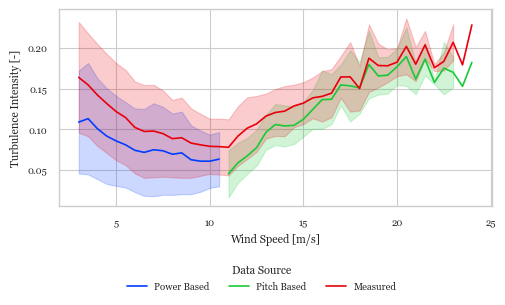

In [10]:
WIDTH, HEIGHT = setup_plot(.5)
WIDTH, HEIGHT = WIDTH*.8, HEIGHT
# Filter the data
df_filtered = df[(df.turbine == 1) & (df.year == 2022) & (~df.is_Abnormal)]

# Create a figure
fig = plt.figure(figsize=(WIDTH, HEIGHT))


sns.lineplot(data=df_filtered, x="wsp_binned", y="TI_est", errorbar="sd",
             hue="Model", palette=[palette[0], palette[2]])
sns.lineplot(data=df_filtered, x="wsp_binned", y="TI_mes",
             errorbar="sd", color=palette[3], label="Measured")

plt.ylabel('Turbulence Intensity [-]')
plt.xlabel('Wind Speed [m/s]')
plt.legend(frameon=False, ncol=3, loc='upper right', bbox_to_anchor=(0.8, -0.25), title="Data Source")
plt.tight_layout()

### Normal and Abnormal Data

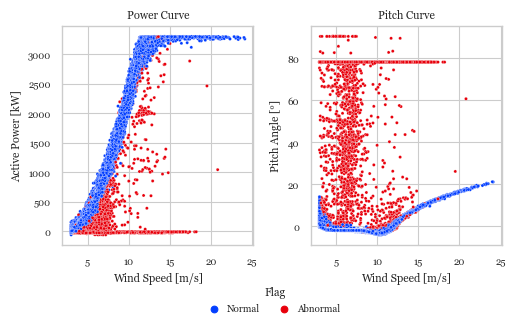

In [11]:
WIDTH, HEIGHT = setup_plot(.5)
WIDTH, HEIGHT = WIDTH*.9, HEIGHT*.9

# Filter the data
df_filtered = df_all[(df_all.turbine == 1) & (df_all.year == 2022)]

# Create a figure with two subplots in a column layout
fig, axs = plt.subplots(1, 2, figsize=(WIDTH, HEIGHT))
color_map = {
    True: palette[3],
    False: palette[0]
}
# Plot avg_power
sns.scatterplot(data=df_filtered, x=wsp_avg, y=power_avg,
                hue='is_Abnormal', ax=axs[0], s=5, palette=color_map)
axs[0].set_title('Power Curve')
axs[0].set_ylabel('Active Power [kW]')
axs[0].set_xlabel('Wind Speed [m/s]')
axs[0].get_legend().remove()

# Plot pitch_avg
sns.scatterplot(data=df_filtered, x=wsp_avg, y=pitch_avg,
                hue='is_Abnormal', ax=axs[1], s=5, palette=color_map)
axs[1].set_title('Pitch Curve')
axs[1].set_ylabel('Pitch Angle [°]')
axs[1].set_xlabel('Wind Speed [m/s]')
axs[1].get_legend().remove()

# Create a centralized legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
labels = ["Normal", "Abnormal"]
# Exclude the first handle and label which is the legend title
plt.legend(handles=handles, labels=labels, title="Flag",
        bbox_to_anchor=(0.2, -0.15), handlelength=1, ncol=2, frameon=False)
plt.subplots_adjust(wspace=.3)